In [3]:
# Importing required libraries
import matplotlib.pyplot as plt
import numpy as np


In [7]:
"""
Get the matrices A and B for solving the diffusion equation using Crank-Nicolson method.
This function is used for free boundary conditions.

Parameters:
- N: Number of spatial grid points
- sigma: alpha*dt/dx^2

Returns:
- A: Matrix A
- B: Matrix B
"""

def diff_matrix_free_boundary(N, sigma):
    # Initialize matrices A and B with zeros
    A = [[0] * N for _ in range(N)]
    B = [[0] * N for _ in range(N)]

    # Fill diagonal and off-diagonal values for matrices A and B
    for i in range(N):
        A[i][i] = 2 + 2 * sigma  # Diagonal element of A
        B[i][i] = 2 - 2 * sigma  # Diagonal element of B

        # Connect to the left neighbor (if not on the left edge)
        if i > 0:
            A[i][i - 1] = -sigma
            B[i][i - 1] = sigma

        # Connect to the right neighbor (if not on the right edge)
        if i < N - 1:
            A[i][i + 1] = -sigma
            B[i][i + 1] = sigma

    return A, B

"""
Get the matrices A and B for solving the diffusion equation using Crank-Nicolson method.
This function is used for isolated boundary conditions.

Parameters:
- N: Number of spatial grid points
- sigma: alpha*dt/dx^2

Returns:
- A: Matrix A
- B: Matrix B
"""

def diff_matrix_isolated_boundary(N, sigma):
    # Initialize matrices A and B with zeros
    A = [[0] * N for _ in range(N)]
    B = [[0] * N for _ in range(N)]

    # Fill diagonal and off-diagonal values for matrices A and B
    for i in range(N):
        A[i][i] = 2 + 2 * sigma  # Diagonal element of A
        B[i][i] = 2 - 2 * sigma  # Diagonal element of B

        # Connect to the left neighbor (if not on the left edge)
        if i > 0:
            A[i][i - 1] = -sigma
            B[i][i - 1] = sigma

        # Connect to the right neighbor (if not on the right edge)
        if i < N - 1:
            A[i][i + 1] = -sigma
            B[i][i + 1] = sigma

    # Boundary conditions
    A[0][0] = 2 + sigma
    B[0][0] = 2 - sigma
    A[-1][-1] = 2 + sigma
    B[-1][-1] = 2 - sigma

    return A, B



In [8]:
print(np.array(diff_matrix_free_boundary(5, 0.5)[0]))
print('\n')
print(np.array(diff_matrix_isolated_boundary(5, 0.5)[0]))


[[ 3.  -0.5  0.   0.   0. ]
 [-0.5  3.  -0.5  0.   0. ]
 [ 0.  -0.5  3.  -0.5  0. ]
 [ 0.   0.  -0.5  3.  -0.5]
 [ 0.   0.   0.  -0.5  3. ]]


[[ 2.5 -0.5  0.   0.   0. ]
 [-0.5  3.  -0.5  0.   0. ]
 [ 0.  -0.5  3.  -0.5  0. ]
 [ 0.   0.  -0.5  3.  -0.5]
 [ 0.   0.   0.  -0.5  2.5]]


In [9]:


"""
Solve 1D diffusion equation using Crank-Nicolson method.

Parameters:
- x_max: Extent of the spatial domain
- t_max: Total simulation time
- dx: Spatial step size
- dt: Time step size
- Diff: Thermal diffusivity
- init_cond: Initial condition function
- source_term: Source term function
- boundary: Boundary condition function

Returns:
- u: Temperature distribution over space and time
- x: Spatial grid
- t: Time grid
"""

def crank_nicolson_diffusion(x_max, t_max, dx, dt, Diff, init_cond, source_term, boundary):

    alpha = Diff * dt / (dx**2)

    # Spatial grid
    x = [i*dx for i in range(int(x_max/dx)+1)]
    t = [j*dt for j in range(int(t_max/dt)+1)]

    # Initialize temperature array
    Temp = np.zeros((len(x), len(t)))

    # Initial condition
    for i in range(len(x)):
        Temp[i][0] = init_cond(x[i])

    # Get the matrices for solving the matrix using crank-nicolson method
    A, B = boundary(len(x), alpha)

    A = np.array(A)
    B = np.array(B)

    for j in range(1, len(t)):
        source_vector = np.array([source_term(xi, t[j]) for xi in x])
        Temp[:, j] = np.linalg.solve(A, np.dot(B, Temp[:, j - 1]) + dt * source_vector)

    return Temp, np.array(x), np.array(t)


In [10]:

"""
Plot the solution in both 1D and Heatmap format.

Parameters:
- time_grid: Time grid
- spatial_grid: Spatial grid
- solution: Solution of the diffusion equation

Returns:
- Makes the plots
"""

def plot_diff(time_grid, spatial_grid, solution):

    # Create 2D plots
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    for i in (range(0, len(time_grid), int(len(time_grid)/5))):
        plt.plot(spatial_grid, solution[:, i], label=f'time = {time_grid[i]:.1f}')
    plt.xlabel(r'Grain length ($\mu m$)')
    plt.ylabel(r'Concentration (ppm)')
    plt.title('Diffusion and element partitioning in one grain')
    plt.ylim(np.min(solution)-10, np.max(solution)+10)
    plt.grid()
    plt.legend()

    # Create imshow plot
    plt.subplot(1, 2, 2)
    plt.contourf(*np.meshgrid(spatial_grid, time_grid), solution.T, 40, cmap='Spectral_r')
    plt.colorbar(label=r'Concentration (ppm)')
    plt.title('Diffusion and element partitioning in one grain')
    plt.xlabel('Grain length ($\mu m$)')
    plt.ylabel('Time (s)')
    plt.grid()



### Solving heat diffusion equation on a metal rod with isolated boundary condition on both ends


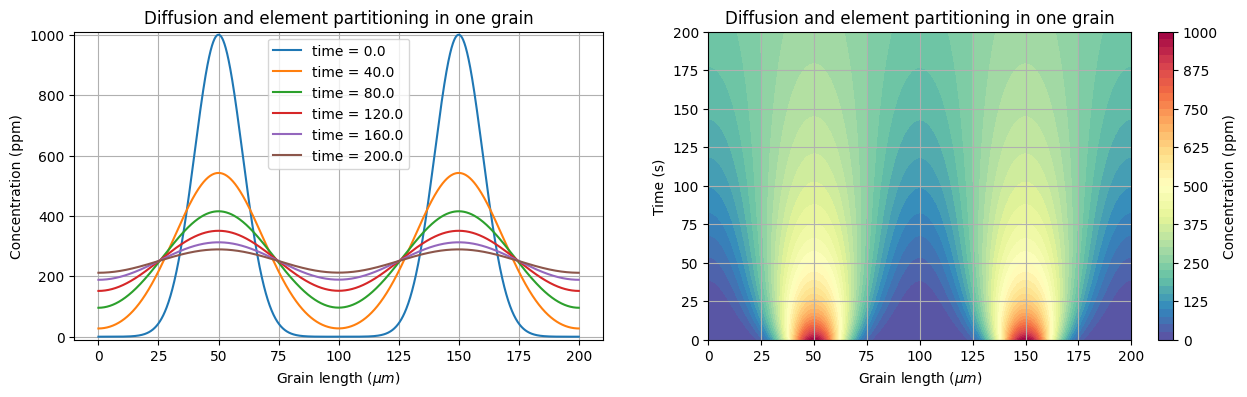

In [11]:
def init_cond(x):
    return 1000*np.exp(-0.005*(x-50)**2) + 1000*np.exp(-0.005*(x-150)**2)

def source_term(x, t):
    return 0 # 10 * np.sin(np.pi * x) * np.exp(-0.1 * t)

# Constants and parameters
alpha_1 = 3    # diffusivity
t_max = 200     # total simulation time
z_max = 200     # length of the grain
dt = 1       # time step
dz = 0.1       # spatial step

solution, spatial_grid, time_grid = crank_nicolson_diffusion(z_max, t_max, dz, dt, alpha_1, init_cond, source_term, diff_matrix_isolated_boundary)

# Plot the diffusion equation solution
plot_diff(time_grid, spatial_grid, solution)

plt.show()


# Diffusion for two grains in contact


In [6]:
# Importing required libraries
import matplotlib.pyplot as plt
import numpy as np

def diff_matrix_isolated_boundary_G2(N1, N, alpha_1, alpha_2):
    # Initialize matrices A and B with zeros
    A = [[0] * N for _ in range(N)]
    B = [[0] * N for _ in range(N)]

    # Fill diagonal and off-diagonal values for matrices A and B
    for i in range(N1):
        A[i][i] = 2 + 2 * alpha_1  # Diagonal element of A
        B[i][i] = 2 - 2 * alpha_1  # Diagonal element of B

        # Connect to the left neighbor (if not on the left edge)
        if i > 0:
            A[i][i - 1] = -alpha_1
            B[i][i - 1] = alpha_1

        # Connect to the right neighbor (if not on the right edge)
        if i < N - 1:
            A[i][i + 1] = -alpha_1
            B[i][i + 1] = alpha_1

    # Fill diagonal and off-diagonal values for matrices A and B
    for i in range(N1, N):
        A[i][i] = 2 + 2 * alpha_2  # Diagonal element of A
        B[i][i] = 2 - 2 * alpha_2  # Diagonal element of B

        # Connect to the left neighbor (if not on the left edge)
        if i > 0:
            A[i][i - 1] = -alpha_2
            B[i][i - 1] = alpha_2

        # Connect to the right neighbor (if not on the right edge)
        if i < N - 1:
            A[i][i + 1] = -alpha_2
            B[i][i + 1] = alpha_2


    # Boundary conditions
    A[0][0] = 2 + alpha_1
    B[0][0] = 2 - alpha_1
    A[-1][-1] = 2 + alpha_2
    B[-1][-1] = 2 - alpha_2

    return A, B


def crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dl, dt, Diff_1, Diff_2, init_cond_1, init_cond_2, source_term, boundary):

    alpha_1 = Diff_1 * dt / (dl**2)
    alpha_2 = Diff_2 * dt / (dl**2)

    # Spatial grid
    N1 = int(L_grain1/dl)
    N2 = int(L_grain2/dl)
    N = N1 + N2
    x = [i*dl for i in range(N+1)]
    t = [j*dt for j in range(int(t_max/dt)+1)]

    # Initialize temperature array
    Temp = np.zeros((len(x), len(t)))

    # Initial condition
    for i in range(N1):
        Temp[i][0] = init_cond_1(x[i], L_grain1, L_grain2)
    for i in range(N1, len(x)):
        Temp[i][0] = init_cond_2(x[i], L_grain1, L_grain2)

    # Get the matrices for solving the matrix using crank-nicolson method
    A, B = boundary(N1, len(x), alpha_1, alpha_2)

    A = np.array(A)
    B = np.array(B)

    for j in range(1, len(t)):
        source_vector = np.array([source_term(xi, t[j]) for xi in x])
        Temp[:, j] = np.linalg.solve(A, np.dot(B, Temp[:, j - 1]) + dt * source_vector)

    return Temp, np.array(x), np.array(t)


def plot_diff(time_grid, spatial_grid, solution):

    # Create 2D plots
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    for i in (range(0, len(time_grid), int(len(time_grid)/5))):
        plt.plot(spatial_grid, solution[:, i], label=f'time = {time_grid[i]:.1f}')
    plt.xlabel(r'Grain length ($\mu m$)')
    plt.ylabel(r'Concentration (ppm)')
    plt.title('Diffusion and element partitioning in one grain')
    plt.ylim(np.min(solution)-10, np.max(solution)+10)
    plt.grid()
    plt.legend()

    # Create imshow plot
    plt.subplot(1, 2, 2)
    plt.contourf(*np.meshgrid(spatial_grid, time_grid), solution.T, 40, cmap='Spectral_r')
    plt.colorbar(label=r'Concentration (ppm)')
    plt.title('Diffusion and element partitioning in one grain')
    plt.xlabel('Grain length ($\mu m$)')
    plt.ylabel('Time (s)')
    plt.grid()


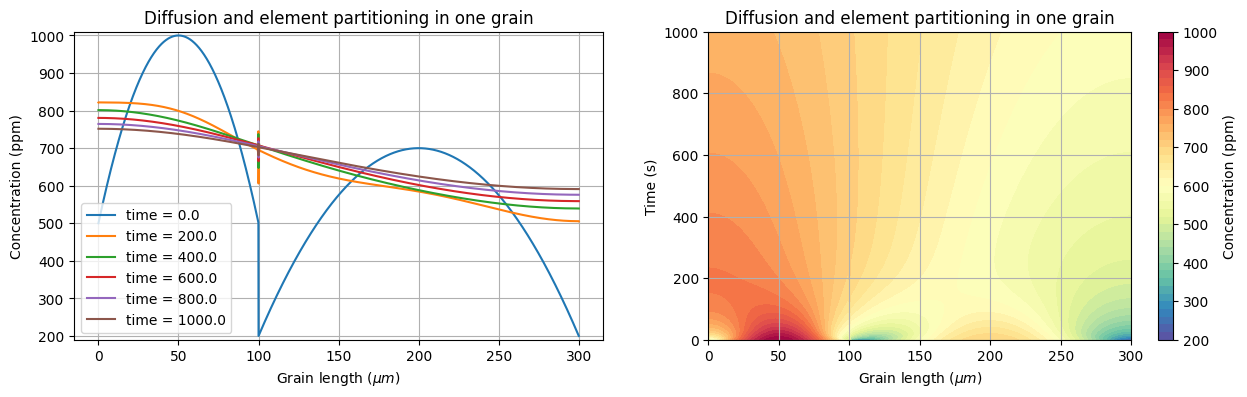

In [10]:
def init_cond_grain_1(x, L_grain1, L_grain2):
    # return 1000*np.exp(-0.001*(x-L_grain1/2)**2)
    return -0.2 * (x - L_grain1/2)**2 + 1000

def init_cond_grain_2(x, L_grain1, L_grain2):
    # return 500*np.exp(-0.001*(x-(L_grain1 + L_grain2/2))**2)
    return -0.05 * (x - (L_grain1 + L_grain2/2))**2 + 700

def source_term(x, t):
    return 0 # 10 * np.sin(np.pi * x) * np.exp(-0.1 * t)

# Constants and parameters
t_max = 200     # total simulation time
Diff_1 = 5    # diffusivity grain 1
Diff_2 = 1    # diffusivity grain 2
L_grain1 = 100     # length of the grain 1
L_grain2 = 200     # length of the grain 2
dt = 1       # time step
dl = 0.1       # spatial step

z_max = L_grain1 + L_grain2

solution, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dl, dt, Diff_1, Diff_2, init_cond_grain_1, init_cond_grain_2, source_term, diff_matrix_isolated_boundary_G2)

# Plot the diffusion equation solution
plot_diff(time_grid, spatial_grid, solution)

plt.show()
